In [177]:
import numpy as np
import untangle
from xml.etree.ElementTree import ElementTree
from io import BytesIO
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import time

# 5 - Bulk Analysis of cell tracks 

In this notebook we will use a combination of detected spots from Mastodon and Masks from labkit in order to choose regions of interest. 

Moreover, we will also be able to edit files from Mastodon in order to be able to observe cell tracks we choose in the user interface of BigDataViewer with Mastodon. 

## Folder and data paths
In the next cell, you need to specify:
- ``path_xml``: Path and file name of the .xml file obtained from converting the data to HDF5/XML is stored.
- ``path_csv``: Path and file name of the .csv file obtained from the tracks from Mastodon. You do not need to add the -edges or -vertices extension.
- ``path_mamut``: Path and dile name of the mamut.xml file obtained from Mastodon. This file can be edited in order to interact with Mastodon. 
- ``path_loi``: Path and file name to the segmented LOI which can be used for adding a new reference frame. 

In [178]:
# Path to .xml file generated when creating the .hdf5
path_xml = '../../Data/Bulk Data/dataset.xml' # Path to .xml file

# Path to mamut.xml file
path_mamut = '../../Data/Bulk Data/dataset_mamut.xml'

# Path to the Labeling
path_labels = '../../Data/Bulk Data/dataset_labels.xml'

In [179]:
obj = untangle.parse(path_mamut)

# Parse .xml file
obj1 = untangle.parse(path_xml)

# Data Features
width = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[0])
height = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[1])
n_slices = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[2])

x_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[0])
y_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[1])
z_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[2])

channels = len(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup)
while True:
    try:
        n_frames = len(obj1.SpimData.SequenceDescription.Timepoints.integerpattern.cdata.split())
        break
    except AttributeError:
        pass  # fallback to dict
    try:
        n_frames = int(obj1.SpimData.SequenceDescription.Timepoints.last.cdata.split()[0])+1
        break
    except KeyError:
        raise AttributeError("There is something wrong with the .xml file") from None
        

units = obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.unit.cdata

print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(width, height, n_slices, channels))
print('There are %d frames in total.'%n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(x_pixel, units, y_pixel, units, z_pixel, units))
print('There are %d Z-slices in total'%n_slices)

The image has the following dimensions (XYZC): 1222, 1732, 150, 2
There are 20 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


In [180]:
n_spots = int(obj.TrackMate.Model.AllSpots['nspots'])
print('There are %d number of cells in total in Looping.'%n_spots)

There are 257115 number of cells in total in Looping.


## Ordering the tracks ID

Create a list called ``spots_track_ID`` which has the following structure:

[ track number 1: { spot ID 1, spot ID 2, ... } ] ; [ track number 2: { spot ID 1, spot ID 2, ... } ] ; ...

Each track represents the entire track of a single cell and each spot corresponds to the cell in a given frame. 

In [181]:
# Create array with the ID of each track
spots_xpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ypos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_zpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ID_per_frame =  {key:[] for key in np.arange(n_frames)}

for i in range(n_frames):

    n_spots_in_frame = len(obj.TrackMate.Model.AllSpots.SpotsInFrame[i]) 
    for j in range(n_spots_in_frame):

        spots_xpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame[i].Spot[j]['POSITION_X']))
        spots_ypos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame[i].Spot[j]['POSITION_Y']))
        spots_zpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame[i].Spot[j]['POSITION_Z']))
        spots_ID_per_frame[i].append(int(obj.TrackMate.Model.AllSpots.SpotsInFrame[i].Spot[j]['ID']))

### Plot the results

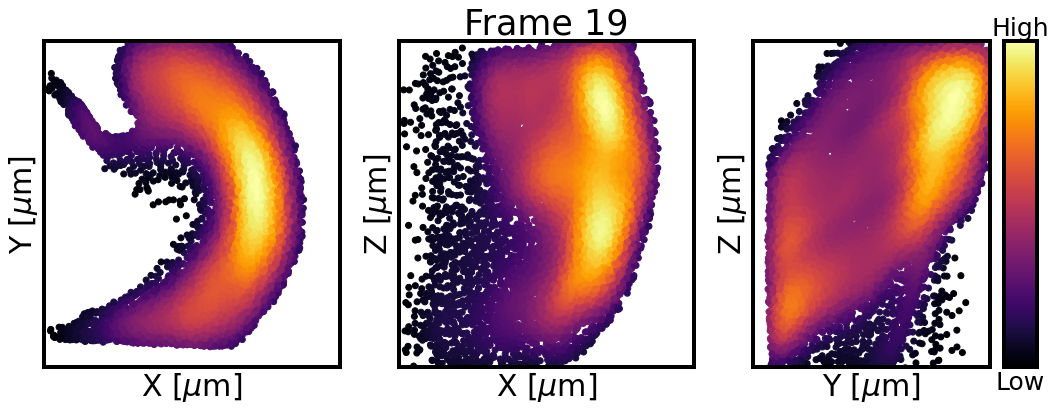

In [182]:
fig = plt.figure(figsize=[18,6])

frame = 19
cmap='inferno'

ax = fig.add_subplot(131)
# Calculate the point density
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_ypos_per_frame[frame], c=z, cmap=cmap)
plt.xlabel('X [$\mu$m]', fontsize=30)
plt.ylabel('Y [$\mu$m]', fontsize=30)
plt.xticks([])
plt.yticks([])
plt.ylim([0, height*y_pixel])
plt.xlim([0, width*x_pixel])
[i.set_linewidth(4) for i in ax.spines.values()]
#plt.gca().invert_yaxis()

ax = fig.add_subplot(132)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_zpos_per_frame[frame], c=z, cmap=cmap)
plt.xlabel('X [$\mu$m]', fontsize=30)
plt.ylabel('Z [$\mu$m]', fontsize=30)
plt.xticks([])
plt.yticks([])
plt.ylim([0, n_slices*z_pixel])
plt.xlim([0, width*x_pixel])
#plt.gca().invert_yaxis()
[i.set_linewidth(4) for i in ax.spines.values()]
plt.title('Frame %d'%frame, fontsize=35)

ax = fig.add_subplot(133)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_ypos_per_frame[frame], spots_zpos_per_frame[frame], c=z, cmap=cmap)
plt.xlabel('Y [$\mu$m]', fontsize=30)
plt.ylabel('Z [$\mu$m]', fontsize=30)
plt.xticks([])
plt.yticks([])
plt.ylim([0, n_slices*z_pixel])
plt.xlim([0, height*y_pixel])
[i.set_linewidth(4) for i in ax.spines.values()]
#plt.gca().invert_yaxis()


cb = plt.colorbar(ticks=[], aspect=10)
cb.outline.set_linewidth(4)
#cb.ax.set_yticklabels(['Low', 'High'], fontsize=25)
cb.ax.text(0.5, -0.01, 'Low', transform=cb.ax.transAxes, 
    va='top', ha='center', fontsize=25)
cb.ax.text(0.5, 1.0, 'High', transform=cb.ax.transAxes, 
    va='bottom', ha='center', fontsize=25)

#plt.tight_layout()
plt.show()

## LabKit Data

In [39]:
labeling_file = open(path_labels, "r")
for line in labeling_file:
    pass

labeling_dict = eval(line)

In [40]:
n_labels = len(labeling_dict['labels'].keys())
labels = list(labeling_dict['labels'].keys())

In [41]:
data_dict = {'X': [], 'Y': [], 'Z': [], 'T': [], 'Labels': []}

for label in labels:
    labels_vals = labeling_dict['labels'][label]
    x_aux = []
    y_aux = []
    z_aux = []
    t_aux = []
    
    for i in range(len(labels_vals)):
        x_aux.append(labels_vals[i][0])
        y_aux.append(labels_vals[i][1])
        z_aux.append(labels_vals[i][2])
        t_aux.append(labels_vals[i][3])

    data_dict['X'] += x_aux
    data_dict['Y'] += y_aux
    data_dict['Z'] += z_aux
    data_dict['T'] += t_aux
    data_dict['Labels']+= [label]*len(labels_vals)

In [42]:
data_df = pd.DataFrame(data_dict)
data_df.head()

,X,Y,Z,T,Labels
0,829,651,26,19,PSM
1,829,652,26,19,PSM
2,829,653,26,19,PSM
3,829,650,27,19,PSM
4,829,651,27,19,PSM


In [66]:
masks = [np.zeros((width, height)),
        np.zeros((width, n_slices)),
        np.zeros((height, n_slices))]

count = 0

for label in labels:
    x = data_df.loc[data_df['Labels']==label]['X'].to_numpy()
    y = data_df.loc[data_df['Labels']==label]['Y'].to_numpy()
    z = data_df.loc[data_df['Labels']==label]['Z'].to_numpy()
    t = data_df.loc[data_df['Labels']==label]['T'].to_numpy()
    
    bitmap = np.zeros((width, height, n_slices))
    bitmap[x,y,z] = 1+count
    
    # XY
    masks[0] += np.max(bitmap, axis=2)
    
    # XZ
    masks[1] += np.max(bitmap, axis=1)
    
    # ZY
    masks[2] += np.max(bitmap, axis=0)
    
    count += 1

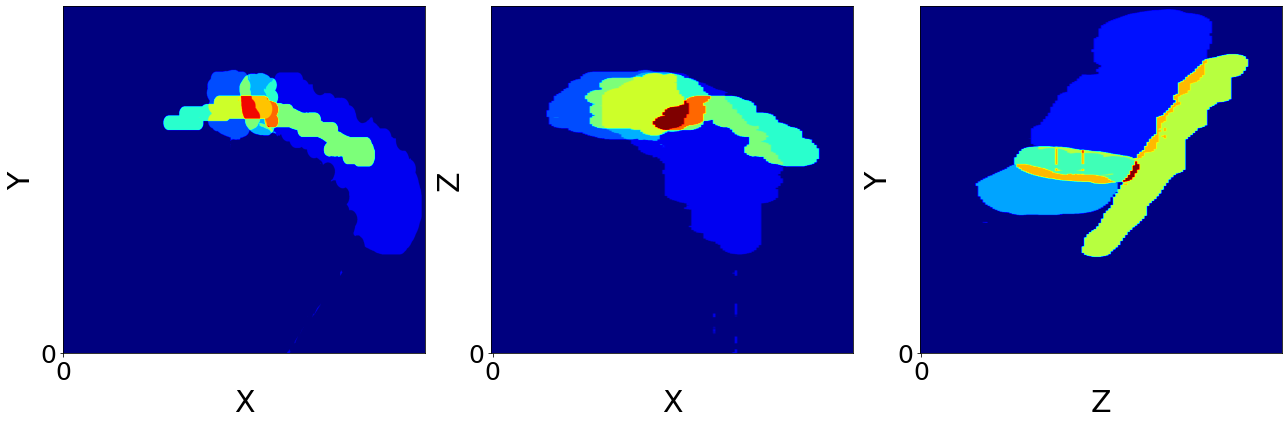

In [67]:
plt.figure(figsize=[18,6])

plt.subplot(131)
plt.imshow(masks[0], cmap='jet', alpha=1, aspect='auto')
plt.xticks(np.arange(1), fontsize=25);
plt.yticks(np.arange(1), fontsize=25);
plt.xlabel('X', fontsize=30)
plt.ylabel('Y', fontsize=30)

plt.gca().invert_yaxis()

plt.subplot(132)
plt.imshow(masks[1], cmap='jet', alpha=1, aspect='auto')
plt.xticks(np.arange(1), fontsize=25);
plt.yticks(np.arange(1), fontsize=25);
plt.xlabel('X', fontsize=30)
plt.ylabel('Z', fontsize=30)
plt.gca().invert_yaxis()

plt.subplot(133)
plt.imshow(masks[2], cmap='jet', alpha=1, aspect='auto')
plt.xticks(np.arange(1), fontsize=25);
plt.yticks(np.arange(1), fontsize=25);
plt.xlabel('Z', fontsize=30)
plt.ylabel('Y', fontsize=30)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Spots tp keep according to labeling

In [128]:
spots_to_keep = []
spots_to_remove = []
frames_to_remove = []
spots_to_keep_ID = []
spots_to_remove_ID = []
spots_to_remove_label = []

for label in labels:
    x = data_df.loc[data_df['Labels']==label]['X'].to_numpy()
    y = data_df.loc[data_df['Labels']==label]['Y'].to_numpy()
    z = data_df.loc[data_df['Labels']==label]['Z'].to_numpy()
    t = data_df.loc[data_df['Labels']==label]['T'].to_numpy()
    
    bitmap = np.zeros((width, height, n_slices))
    bitmap[x,y,z] = 1

    spots_to_remove_aux = []
    spots_to_keep_aux = []
    spots_to_keep_ID_aux = []
    spots_to_remove_ID_aux = []
    spots_to_remove_label_aux = []
    frames = np.unique(t)
    t_ = []
    
    for j in frames:
        n_spots = len(spots_xpos_per_frame[j])
        for i in range(n_spots):
            # Convert the spots position into pixels (fromt micrometers)
            x_ = int(np.round(spots_xpos_per_frame[j][i]/x_pixel))
            y_ = int(np.round(spots_ypos_per_frame[j][i]/y_pixel))
            z_ = int(np.round(spots_zpos_per_frame[j][i]/z_pixel))
            ind = int(spots_ID_per_frame[j][i])

            # Check if that position is inside the PSM labeled data
            if x_<width and y_<height and z_<n_slices:
                if bitmap[x_,y_,z_]==0:
                    spots_to_remove_aux.append(i)
                    spots_to_remove_ID_aux.append(ind)
                    spots_to_remove_label_aux.append(label)
                    t_.append(j)
                else:
                    spots_to_keep_aux.append(i)
                    spots_to_keep_ID_aux.append(ind)
            else:
                spots_to_remove_aux.append(i)
                spots_to_remove_ID_aux.append(ind)
                spots_to_remove_label_aux.append(label)
                t_.append(j)
            
    spots_to_keep.append(spots_to_keep_aux)
    spots_to_remove.append(spots_to_remove_aux)
    frames_to_remove.append(t_)
    spots_to_remove_ID.append(spots_to_remove_ID_aux)
    spots_to_keep_ID.append(spots_to_remove_ID_aux)
    spots_to_remove_label.append(spots_to_remove_label_aux)
    

### Spots to keep plot

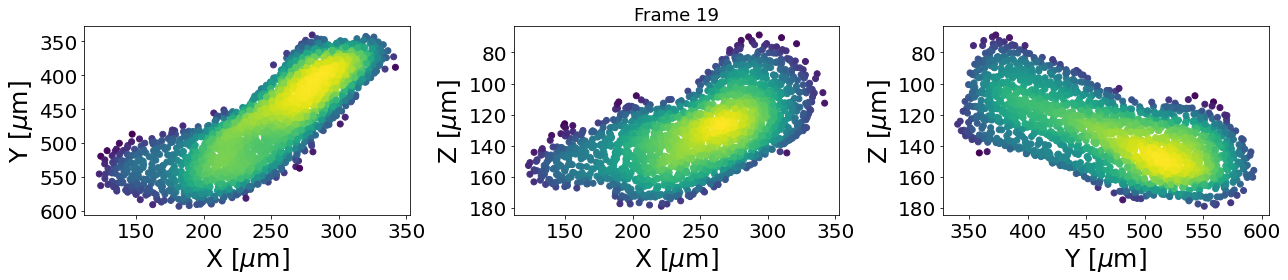

In [97]:
plt.figure(figsize=[18,4])

frame = 19
label = 0

plt.subplot(131)
# Calculate the point density
xy = np.vstack([np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep[label])],\
                np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep[label])]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep[label])],\
            np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep[label])], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep[label])]\
                ,np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep[label])]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep[label])],\
            np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep[label])], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
xy = np.vstack([np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep[label])],\
                np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep[label])]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep[label])],\
            np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep[label])], c=z)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

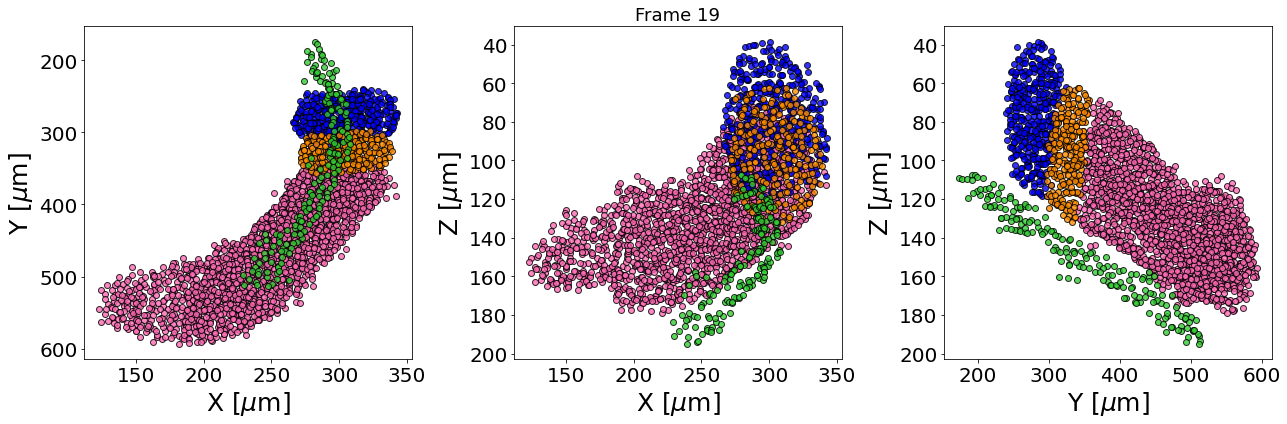

In [125]:
plt.figure(figsize=[18,6])

frame = 19

colors = ['hotpink', 'blue', 'darkorange', 'limegreen', 'teal']
plt.subplot(131)
# Calculate the point density
for label in range(len(labels)):
    z = colors[label]
    plt.scatter(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep[label])],\
                np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep[label])], 
                c=z, edgecolor='k', alpha=0.8)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
for label in range(len(labels)):
    z = colors[label]
    plt.scatter(np.array(spots_xpos_per_frame[frame])[np.array(spots_to_keep[label])],\
                np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep[label])], 
                c=z, edgecolor='k', alpha=0.8)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
for label in range(len(labels)):
    z = colors[label]
    plt.scatter(np.array(spots_ypos_per_frame[frame])[np.array(spots_to_keep[label])],\
                np.array(spots_zpos_per_frame[frame])[np.array(spots_to_keep[label])], 
                c=z, edgecolor='k', alpha=0.8)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Remove Spots which are not in the PSM

In [172]:
# FOR EACH LABEL

i = 0 # Label 0 
frame = 19

# Open the  XML file of your original data to write and edit
# Then we will save and edit a new xml file

tree = ElementTree()
tree.parse(path_mamut)

# XML Declaration

f = BytesIO()
tree.write(f, encoding='utf-8', xml_declaration=True)

# Correct the units
units = 'micron'
for TrackMate in tree.iter('TrackMate'):
    for Model in TrackMate.iter('Model'):
        
        # Change value
        Model.set('spatialunits', '%s'%units)
        
        
n_spots_left = n_spots - len(spots_to_keep_ID[i])

# First thing to change is "nspots":
for Model in tree.iter('Model'):
    for AllSpots in Model.iter('AllSpots'):
        # Change value
        AllSpots.set('nspots', '%d'%n_spots_left)
        
t = time.time()    

spots_ID_to_remove = np.array(spots_to_remove_ID[i])

# Delete the Spots that are no longer in the tracks of interest
for SpotsInFrame in tree.iter('SpotsInFrame'):
    for Spot in SpotsInFrame.findall('Spot'):
        
        if len(np.where(int(Spot.attrib['ID'])==spots_ID_to_remove)[0])>0:
            SpotsInFrame.remove(Spot)
            
print(time.time() - t)

# Write a new xml with only the kept spots
tree.write('../../Data/Bulk Data/%s_dataset-mamut.xml'%labels[i])
elapsed = time.time() - t
print('Time in seconds: %d'%elapsed)

1.9277799129486084
Time in seconds: 11


### Check curated data

Once the new xml has been manually curated in Mastodon, we can plot the resulting data.

In [174]:
path_mamut = '../../Data/Bulk Data/%s_dataset-mamut.xml'%labels[i]

n_frames = 1
obj = untangle.parse(path_mamut)

# Parse .xml file
obj1 = untangle.parse(path_xml)

# Data Features
width = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[0])
height = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[1])
n_slices = int(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[2])

x_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[0])
y_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[1])
z_pixel = float(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[2])

channels = len(obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup)
while True:
    try:
        n_frames = len(obj1.SpimData.SequenceDescription.Timepoints.integerpattern.cdata.split())
        break
    except AttributeError:
        pass  # fallback to dict
    try:
        n_frames = int(obj1.SpimData.SequenceDescription.Timepoints.last.cdata.split()[0])+1
        break
    except KeyError:
        raise AttributeError("There is something wrong with the .xml file") from None
        

units = obj1.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.unit.cdata

print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(width, height, n_slices, channels))
print('There are %d frames in total.'%n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(x_pixel, units, y_pixel, units, z_pixel, units))
print('There are %d Z-slices in total'%n_slices)

The image has the following dimensions (XYZC): 1222, 1732, 150, 2
There are 20 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


In [175]:
n_spots = int(obj.TrackMate.Model.AllSpots['nspots'])
print('There are %d number of cells in total in Looping.'%n_spots)

There are 245974 number of cells in total in Looping.


### Ordering the tracks ID
Create a list called *spots_track_ID* which has the following structure:

[ track number 1: { spot ID 1, spot ID 2, ... } ] ; [ track number 2: { spot ID 1, spot ID 2, ... } ] ; ...

Each track represents the entire track of a single cell and each spot corresponds to the cell in a given frame. 

In [176]:
# Create array with the ID of each track
spots_ch0_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ch1_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_xpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ypos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_zpos_per_frame =  {key:[] for key in np.arange(n_frames)}
spots_ID_per_frame =  {key:[] for key in np.arange(n_frames)}


i = 0

n_spots_in_frame = len(obj.TrackMate.Model.AllSpots.SpotsInFrame) # For Looping
for j in range(n_spots_in_frame):
    spots_ch0_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['Spot_gaussian-filtered_intensity_Mean_ch0']))
    spots_ch1_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['Spot_gaussian-filtered_intensity_Mean_ch1']))
    spots_xpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_X']))
    spots_ypos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_Y']))
    spots_zpos_per_frame[i].append(float(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['POSITION_Z']))
    spots_ID_per_frame[i].append(int(obj.TrackMate.Model.AllSpots.SpotsInFrame.Spot[j]['ID']))

AttributeError: 'list' object has no attribute 'Spot'

### Plot the results

In [ ]:
plt.figure(figsize=[18,4])

frame = 0

plt.subplot(131)
# Calculate the point density
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_ypos_per_frame[frame], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_zpos_per_frame[frame], c=z)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_ypos_per_frame[frame], spots_zpos_per_frame[frame], c=z)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
y_sub_xy = subsampling*y_ref_xy
x_sub_xy = subsampling*x_ref_xy

'''
ind = np.where(y_ref_yz[1,:]==frame)[0]
y_sub_yz = subsampling*(y_ref_yz[0,ind])
z_sub_yz = 150-z_ref_yz[0,ind]

ind = np.where(x_ref_xz[1,:]==frame)[0]
x_sub_xz = subsampling*(x_ref_xz[0,ind])
z_sub_xz = 150-z_ref_xz[0,ind]
'''
# Calculate the point densitys
plt.figure(figsize=[8,6])

frame = 0
#plt.subplot(131)
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(np.abs(spots_xpos_per_frame[frame]-np.abs(x_sub_xy[0]-R[0])*x_pixel)/x_pixel), \
            np.array(np.abs(spots_ypos_per_frame[frame]+np.abs(y_sub_xy[0]-R[1])*y_pixel)/y_pixel), c=z)
plt.scatter(np.abs(x_sub_xy-np.abs(x_sub_xy[0]-R[0])), np.abs(y_sub_xy+np.abs(y_sub_xy[0]-R[1])), s=10, c='red')
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)
plt.xticks(np.arange(0,2048+256,256), fontsize=18)
plt.yticks(np.arange(0,2048+256,256),fontsize=18)

plt.gca().invert_yaxis()
'''
plt.subplot(132)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_ypos_per_frame[frame])/y_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
plt.scatter(y_sub_yz, z_sub_yz, s=10, c='red')
plt.xlabel('Y $\mu$m', fontsize=14)
plt.ylabel('Z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.subplot(133)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(np.array(spots_xpos_per_frame[frame])/x_pixel, np.array(spots_zpos_per_frame[frame])/z_pixel, c=z, edgecolor='', alpha=1)
plt.scatter(x_sub_xz, z_sub_xz, s=10, c='red')
plt.xlabel('X $\mu$m', fontsize=14)
plt.ylabel('z $\mu$m', fontsize=14)
plt.gca().invert_yaxis()

plt.tight_layout()
'''
plt.show()

# Create a Graph - GRAPH FOURIER TRANSFORM ANALYSIS

### Arrange the data

In [ ]:
# In micrometers!
x_p = np.array(spots_xpos_per_frame[frame])
y_p = np.array(spots_ypos_per_frame[frame])
z_p = np.array(spots_zpos_per_frame[frame])

intensity = np.array(spots_ch0_per_frame[frame])

xyz_matrix = np.array([x_p, y_p, z_p]).T

### Adjacency Matrix of the Graph

In [ ]:
dist_matrix = squareform(pdist(xyz_matrix))

ax = plt.imshow(dist_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks(np.arange(0,2500,700), fontsize=18)
plt.yticks(np.arange(0,2500,700), fontsize=18)
plt.xlabel('Cells', fontsize=20)
plt.ylabel('Cells', fontsize=20)

Now we want to keep the local edges, e.g. the cells which are neighbors. 

### $\epsilon$ - ball Method

In [ ]:
# Radius in micrometers
epsilon = 12

mask = dist_matrix<=epsilon

# Make diagonal equal to 0
mask[np.diag_indices(len(mask))] = 0

plt.imshow(mask, vmax=0.05)
plt.colorbar()

To choose $\epsilon$ we can check with how many cells each one of them is connected. For that we do:

In [ ]:
# Check Neighbors distribution with different radius sizes
dim = 0

eps = [8,9,10,11,12,13,14,15,16]


n_cols =  3
n_rows = np.ceil((len(eps) + 1) / n_cols)
plot_num = 1


ax = plt.figure(figsize=[18,12])
aux = []

for j in range(len(eps)):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    mask = dist_matrix<=eps[j]

    # Make diagonal equal to 0
    mask[np.diag_indices(len(mask))] = 0
    
    aux.append(np.sum(mask, dim))
    
    plt.hist(np.sum(mask, dim), edgecolor='black', linewidth=2)
    
    
    locs, labels = plt.xticks()
    plt.xticks(locs[1:], map(int,locs[1:]), fontsize=20);
    plt.yticks(fontsize=20);
    plt.ylabel('Number of cells', fontsize=25)
    plt.xlabel('Number of neighbors', fontsize=25)
    plt.title('$\epsilon= %d \mu m$'%eps[j], fontsize=30)
plt.tight_layout()
plt.show()

In [ ]:
bins=np.histogram(np.hstack((aux)), bins=10)[1] #get the bin edges

In [ ]:
# Is there any cell not connected? If 0, then yes otherwise no
np.min(np.sum(mask,dim))

### Ridge Plot 

To better see the distribution of cells according to their number of neighbours. 

In [ ]:
# Check Neighbors distribution with different radius sizes
dim = 0

eps = [8,9,10,11,12,13,14,15,16]


n_cols =  1
n_rows = np.ceil((len(eps) + 1) / n_cols)
plot_num = 1


ax = plt.figure(figsize=[4,10])

for j in range(len(eps)):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if j!= len(eps):
        ax.set_xticklabels([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
    if j == len(eps)-1:
        ax.spines['bottom'].set_visible(True)
        
    mask = dist_matrix<=eps[j]

    # Make diagonal equal to 0
    mask[np.diag_indices(len(mask))] = 0

    plt.hist(np.sum(mask, dim), color='grey',edgecolor='black', linewidth=2, bins=bins)
    plt.xlim([0,25])
    
    plt.ylabel('$\epsilon$ = %d $\mu m$'%eps[j], fontsize=20, rotation=0,labelpad=-300)
    
    if j==len(eps)-1:
        locs, labels = plt.xticks()
        plt.xticks(locs, map(int,locs), fontsize=20);
        plt.yticks([]);
        #plt.ylabel('Number of cells', fontsize=25)
        plt.xlabel('Number of neighbors', fontsize=25)
    else:
        plt.xticks([])
        plt.yticks([])
    #plt.title('$\epsilon= %d \mu m$'%eps[j], fontsize=30)
    
    
plt.tight_layout(pad=-5)
plt.show()

## Variability Analysis

$x_{i}$: Intensity of cell $i$. 

$v_{i}$:Variability of cell $i$.

$v_{i}=\sum_{j\in N_{i}} \frac{(x_{i}-y_{j})^{2}}{N_{i}}$

In [ ]:
cells_with_no_neighbors = []
cell_variability = []
cell_norm_variability = []

for i in range(n_spots):
    # Find the neighbors of cell i
    neighbors = np.where(mask[i,:]==1)[0]
    
    # Obtain the intensity of cell i 
    x_i = intensity[i]
    
    # If there are neighbors
    if np.size(neighbors)>0:
        aux = 0
        for j in neighbors:
            y_i = intensity[j]
            aux += (x_i-y_i)**2
        
        cell_variability.append(np.sqrt(aux/len(neighbors)))
        cell_norm_variability.append(aux/x_i)
        
       
    # Save the position of the cells which have no neighbors
    else:
        cells_with_no_neighbors.append(i)
        cell_variability.append(np.nan)
        cell_norm_variability.append(np.nan)

## Plot the results

In [ ]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.scatter(x_p, y_p, c=cell_variability, alpha=1)
plt.colorbar()

plt.title('Local Variability', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.subplot(122)
plt.scatter(x_p, y_p, c=intensity, alpha=1)
plt.colorbar()

plt.title('Intensity', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tight_layout()
plt.show()

## Project to the Notochord

### Equidistant points: to increase spatial resolution

In [ ]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

list(getEquidistantPoints((1,1), (5,5), 4))[0]

x_not_equidist = []
y_not_equidist = []
notochord_points = len(x_sub_xy)
n_points = 20 # Number of points to add 
    
# Initial number of points from fiji
x = x_sub_xy
y = y_sub_xy

x_aux = []
y_aux = []

for j in range(notochord_points-1):
    aux = list(getEquidistantPoints((x[j],y[j]),(x[j+1],y[j+1]), n_points))

    # For each of the inserted points
    for k in range(len(aux)-1):
        x_aux.append(aux[k][0])
        y_aux.append(aux[k][1])

x_not_equidist.append(x_aux)
y_not_equidist.append(y_aux)
    
print('Number of timepoints: %d'%np.shape(x_not_equidist)[0])
print('Number of points per timepoint: %d'%np.shape(x_not_equidist)[1])

In [ ]:
plt.figure(figsize=[6,4])

plt.scatter(x_sub_xy, y_sub_xy, s=30, color='blue')
plt.scatter(x_not_equidist, y_not_equidist, s=1,color='orange')


plt.xticks(np.arange(0,2050, 500), fontsize=20)
plt.yticks(np.arange(0,2050, 500),fontsize=20)
plt.xlabel('X [pixels]', fontsize=20)
plt.ylabel('Y [pixels]', fontsize=20)

In [ ]:
mask = dist_matrix<=epsilon

# Make diagonal equal to 0
mask[np.diag_indices(len(mask))] = 0

# Number of neighbors per cell
n_neighbors = []

for i in range(n_spots):
    n_neighbors.append(len(np.where(mask[i,:]==True)[0]))

n_neighbors = np.array(n_neighbors)

In [ ]:
ax = plt.figure(figsize=[12,6])

tp = 0
plt.plot(np.array(x_not_equidist[tp])*x_pixel, (np.array(y_not_equidist[tp]))*y_pixel, linewidth=3, color='red')
plt.plot(x_not_equidist[tp][0]*x_pixel,(y_not_equidist[tp][0])*y_pixel,'o',color='black', markersize=15 )

plt.scatter(spots_xpos_per_frame[tp], spots_ypos_per_frame[tp], c=n_neighbors, edgecolor='black', linewidth=1, s=80, alpha=1)

plt.xlim([0,2048*x_pixel])
plt.ylim([0,2048*y_pixel])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('X [um]', fontsize=25)
plt.ylabel('Y [um]', fontsize=25)
cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=16)
plt.gca().invert_yaxis()

plt.show()

In [ ]:
plt.figure(figsize=[18,4])

frame = 0

plt.subplot(131)
# Calculate the point density
xy = np.vstack([spots_xpos_per_frame[frame],spots_ypos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_ypos_per_frame[frame], c=n_neighbors)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Y [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.subplot(132)
xy = np.vstack([spots_xpos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_xpos_per_frame[frame], spots_zpos_per_frame[frame], c=n_neighbors)
plt.xlabel('X [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()
plt.title('Frame %d'%frame, fontsize=18)

plt.subplot(133)
xy = np.vstack([spots_ypos_per_frame[frame],spots_zpos_per_frame[frame]])
z = gaussian_kde(xy)(xy)
plt.scatter(spots_ypos_per_frame[frame], spots_zpos_per_frame[frame], c=n_neighbors)
plt.xlabel('Y [$\mu$m]', fontsize=25)
plt.ylabel('Z [$\mu$m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### Project the positions into the line of reference: the notochord

We use the most posterior point as out 0 position, meaning that the closer to the tailbud, the smaller the distance to the reference will be. 

In [ ]:
# Projection function

def projectionNotochord(x,y,x_not,y_not):
    # Reference pointa
    x_0 = x_not[0]
    y_0 = y_not[0]
    
    # Calculate the projection to the notochord line
    ind_proj = np.argmin(np.sqrt((x-x_not)**2+(y-y_not)**2))
    
    # Calculate the distance from the projection to the reference point
    #distance_to_ref = np.sqrt((x_not[ind_proj]-x_0)**2+(y_not[ind_proj]-y_0)**2)
    
    return ind_proj#distance_to_ref

In [ ]:
# Project the rest of the cells
proj_dist_all = []

# For each cell tracked
for i in range(n_spots):
    
    distance = []
    
    # For each of the timepoints
    for j in range(n_frames):
        
        x = spots_xpos_per_frame[j][i]
        y = spots_ypos_per_frame[j][i]
        
        # Find the projected value
        distance.append(projectionNotochord(x, y,\
                                np.array(x_not_equidist[j])*x_pixel, \
                                            np.array(y_not_equidist[j])*x_pixel))

    proj_dist_all.append(distance[0])
    
projections = np.array(proj_dist_all)

In [ ]:
# Calculate the mean over the projection
mean_intensity = []
std_intensity = []
mean_cell_variability = []
std_cell_variability = []
mean_cell_norm_variability = []
std_cell_norm_variability = []

for i in np.unique(projections):
    inds = np.where(projections==i)[0]
    mean_intensity.append(np.nanmean(np.array(intensity)[inds]))
    std_intensity.append(np.nanstd(np.array(intensity)[inds]))
    mean_cell_variability.append(np.nanmean(np.array(cell_variability)[inds]))
    std_cell_variability.append(np.nanstd(np.array(cell_variability)[inds]))
    mean_cell_norm_variability.append(np.nanmean(np.array(cell_norm_variability)[inds]))
    std_cell_norm_variability.append(np.nanstd(np.array(cell_norm_variability)[inds]))

mean_intensity = np.array(mean_intensity)
std_intensity = np.array(std_intensity)
mean_cell_variability = np.array(mean_cell_variability)
std_cell_variability = np.array(std_cell_variability)
mean_cell_norm_variability = np.array(mean_cell_norm_variability)
std_cell_norm_variability = np.array(std_cell_norm_variability)

In [ ]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.scatter(projections-np.min(projections), intensity, alpha=0.5, color='pink', edgecolors='deeppink', linewidth=1.5, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='darkgreen', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(250,2500,500),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([250,2300])

plt.subplot(122)
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='black', label='Mean')
plt.fill_between(np.unique(projections)-np.min(projections), mean_intensity-std_intensity,\
                 mean_intensity+std_intensity, alpha = 0.5, color='blue', label='Std')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks([])
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylim([250,2300])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[6,4])
plt.scatter(projections-np.min(projections), intensity, alpha=0.8, color='magenta', edgecolors='mediumvioletred', linewidth=1.5, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='limegreen', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(250,2500,500),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([250,2300])

plt.show()

In [ ]:
plt.figure(figsize=[12,4])

plt.subplot(121)
plt.scatter(projections-np.min(projections), intensity, alpha=0.8, color='grey', edgecolors='black', linewidth=2, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_intensity, color='limegreen', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(250,2500,500),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([250,2300])

plt.subplot(122)
plt.scatter(projections-min(projections), np.log10(cell_norm_variability),alpha=0.8,\
           color='grey', edgecolors='black', linewidths=2)
plt.plot(np.unique(projections)-min(projections), np.log10(mean_cell_norm_variability),\
         color='steelblue',linewidth=2, alpha=1)

plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('Normalized \n Variability', fontsize=25)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.scatter(projections-np.min(projections), cell_variability, alpha=0.5, color='limegreen', edgecolors='green', linewidth=1.5, label='Cells')
plt.plot(np.unique(projections)-np.min(projections), mean_cell_variability, color='black', label='Mean')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(0,900,150),fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('dpERK \n Intensity [gsv]', fontsize=25)
plt.ylim([0,850])

plt.subplot(122)
plt.plot(np.unique(projections)-np.min(projections), mean_cell_variability, color='black', label='Mean')
plt.fill_between(np.unique(projections)-np.min(projections), mean_cell_variability-std_cell_variability,\
                 mean_cell_variability+std_cell_variability, alpha = 0.5, color='blue', label='Std')

plt.legend(fontsize=14)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks([])
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylim([0,850])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[6,4])
plt.scatter(projections-min(projections), np.log10(cell_norm_variability),alpha=0.8,\
           color='deepskyblue', edgecolors='navy', linewidths=2)
plt.plot(np.unique(projections)-min(projections), np.log10(mean_cell_norm_variability),\
         color='orange',linewidth=2, alpha=0.8)

plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('Normalized \n Variability', fontsize=25)
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [ ]:
### Check fano factor

In [ ]:
fig, ax1 = plt.subplots(figsize=[8,4])

color = 'tab:blue'
ax1.set_xlabel('Space [$\mu m$]', fontsize=25)
ax1.set_ylabel('Mean \n Intensity [gsv]', color=color, fontsize=25)
ax1.plot(np.unique(projections)-np.min(projections), mean_intensity, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=20)
ax1.tick_params(axis='x', labelsize=20) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Normalized \n Variability', color=color, fontsize=25)  # we already handled the x-label with ax1
ax2.plot(np.unique(projections)-np.min(projections), np.log10(mean_cell_norm_variability), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=20)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



In [ ]:
np.convolve(x, np.ones(N)/N, mode='valid')

fig, ax1 = plt.subplots(figsize=[8,4])
N = 5
color = 'tab:blue'
ax1.set_xlabel('Space [$\mu m$]', fontsize=25)
ax1.set_ylabel('Mean \n Intensity [gsv]', color=color, fontsize=25)
ax1.plot(np.convolve(mean_intensity, np.ones(N)/N, mode='valid'), color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=20)
ax1.tick_params(axis='x', labelsize=20) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Normalized \n Variability', color=color, fontsize=25)  # we already handled the x-label with ax1
ax2.plot(np.log10(np.convolve(mean_cell_norm_variability, np.ones(N)/N, mode='valid')), color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=20)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()




In [ ]:
np.unique(projections)

In [ ]:
plt.scatter(np.unique(projections)-np.min(np.unique(projections)),np.log10(mean_cell_norm_variability), color='orange', linewidths=1.5, edgecolors='black')
plt.xticks(np.arange(0,500,100), fontsize=20)
plt.yticks(np.arange(0.5,4,1), fontsize=20)
plt.xlabel('Space [$\mu m$]', fontsize=25)
plt.ylabel('Normalized\nVariability', fontsize=25)

plt.show()

In [ ]:
plt.scatter(mean_intensity, np.log10(mean_cell_norm_variability), color='orange', linewidths=1.5, edgecolors='black')
plt.xticks(np.arange(500,2000,350), fontsize=20)
plt.yticks(np.arange(0.5,4,1), fontsize=20)
plt.xlabel('dpERK Intensity [gsv]', fontsize=25)
plt.ylabel('Normalized\nVariability', fontsize=25)

plt.show()

## Tissue level dynamics

Max Projection of the dpERK stain 
2020-11-20, position 1: Planes 55-125 for the max projection
width of the LOI: 80 pixels


In [ ]:
dperk_path = pd.read_csv('20201120_151157_98/dpERKProfile-MaxProj.csv')
dperk_path.head()

In [ ]:
space_len = len(np.convolve(mean_intensity, np.ones(N)/N, mode='valid'))
plt.plot(dperk_path['Distance_(micrometer)']*x_pixel, dperk_path['Gray_Value']/np.max(dperk_path['Gray_Value']), color='black')
plt.plot(np.arange(space_len)*1.7, np.convolve(mean_intensity, np.ones(N)/N, mode='valid')/np.max(mean_intensity), color=color, linewidth=2)



### Adjacency Matrix

Now we are going to build the adjacency matrix:

$S=1-\frac{d}{\epsilon}$

Where $\epsilon$ is the maximum distance ($d_{max}$).

In [ ]:
# From the dist matrix we convert it into a similarity matrix
adj_matrix = (1-dist_matrix/epsilon)*mask



plt.imshow(adj_matrix, vmax=0.01)
plt.colorbar()

### Graph Fourier Transform

In [ ]:
graph = pygsp.graphs.Graph(adj_matrix, lap_type='normalized')

In [ ]:
graph.compute_fourier_basis()

In [ ]:
intensity_rand = np.random.permutation(intensity)
plt.plot(graph.e[1:],graph.gft(intensity)[1:]**2, linewidth=1)
plt.plot(graph.e[1:],graph.gft(intensity_rand)[1:]**2, linewidth=1)

plt.xlim([0,0.1])

In [ ]:
plt.scatter(x_p,y_p,c=graph.U[:,4])

In [ ]:
plt.scatter(x_p, y_p, c=intensity, alpha=0.5, cmap='jet')